# Step 0: Set up

In [ ]:
!pip install torch_geometric

In [ ]:
import torch_geometric
import scipy
import tqdm
print(f"- Python version: {sys.version.split()[0]}")
print(f"- PyTorch version: {torch.__version__}")
print(f"- torch_geometric version: {torch_geometric.__version__}")
print(f"- pandas version: {pd.__version__}")
print(f"- networkx version: {nx.__version__}")
print(f"- NumPy version: {np.__version__}")
print(f"- scikit-learn version: {sklearn.__version__}")
print(f"- SciPy version: {scipy.__version__}")
print(f"- tqdm version: {tqdm.__version__}")


- Python version: 3.11.12
- PyTorch version: 2.6.0+cu124
- torch_geometric version: 2.6.1
- pandas version: 2.2.2
- networkx version: 3.4.2
- NumPy version: 2.0.2
- scikit-learn version: 1.6.1
- SciPy version: 1.14.1
- tqdm version: 4.67.1


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from torch_geometric.nn import SAGEConv
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
import time
from tqdm import tqdm
import sys
import edge_index

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#weather_data = pd.read_csv('weather_station_data.csv')
#passengervolumne = pd.read_csv('/content/PassengerVolume+coordinates(202411).csv')
df_train = pd.read_csv('/content/drive/MyDrive/weather_data/train_data.csv')
df_test = pd.read_csv('/content/drive/MyDrive/weather_data/val_data.csv')
file_path = '/content/drive/MyDrive/st5188/edge_index.py'
sys.path.append('/content/drive/MyDrive/st5188/')

# Step 1: Data Cleaning

In [ ]:
df_train = df_train.drop('is_transfer_hub', axis = 1)
df_test = df_test.drop('total_ridership', axis = 1)

df_test = df_test.rename(columns={
    'day_type': 'is_holiday',
    'latitude': 'Latitude',
    'longitude': 'Longitude'
})

df_test['is_holiday'] = df_test['is_holiday'].map({
    'WEEKENDS/HOLIDAY': 1,
    'WEEKDAY': 0
})

In [ ]:
def process_passenger_volume(df, split_weekend = True):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y/%m/%d %H:%M')
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df = df.dropna(subset=['tap_in'])
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

    if split_weekend:
      weekday_data = df[df['is_holiday'] == 0]
      weekend_data = df[df['is_holiday'] == 1]
      return weekday_data, weekend_data

    else:
      return df

# Step 2: Create graph structure

In [ ]:
edge_start_end, node_mapping = edge_index.edge()
stations = df_train[['station_id', 'Latitude', 'Longitude']].drop_duplicates()
Latitude = stations[stations['station_id'] == 'PE2']['Latitude']
Longitude = stations[stations['station_id'] == 'PE2']['Longitude']
print(f"Latitude: {Latitude.values[0]}, Longitude: {Longitude.values[0]}")


Latitude: 1.396912053, Longitude: 103.9089502


In [ ]:
def create_graph_data(df):
    stations = df[['station_id', 'Latitude', 'Longitude']].drop_duplicates()

    edge_start_end, node_mapping = edge_index.edge()
    node_idx2name = {idx: name for name, idx in node_mapping.items()}

    node_features = [None]*len(node_mapping)

    for station_name, idx in node_mapping.items():
      Latitude = stations[stations['station_id'] == station_name]['Latitude'].values[0]
      Longitude = stations[stations['station_id'] == station_name]['Longitude'].values[0]
      node_features[idx] = [Latitude, Longitude]

    edges = edge_start_end.t().tolist()

    edge_attr = []
    for src_idx, tgt_idx in edges:
        src_lat, src_lon = node_features[src_idx]
        tgt_lat, tgt_lon = node_features[tgt_idx]
        dist = np.sqrt((src_lat - tgt_lat)**2 + (src_lon - tgt_lon)**2)
        edge_attr.append([dist])

    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return node_features, edge_start_end, edge_attr, node_mapping

# Step 3 : Time series features and targets

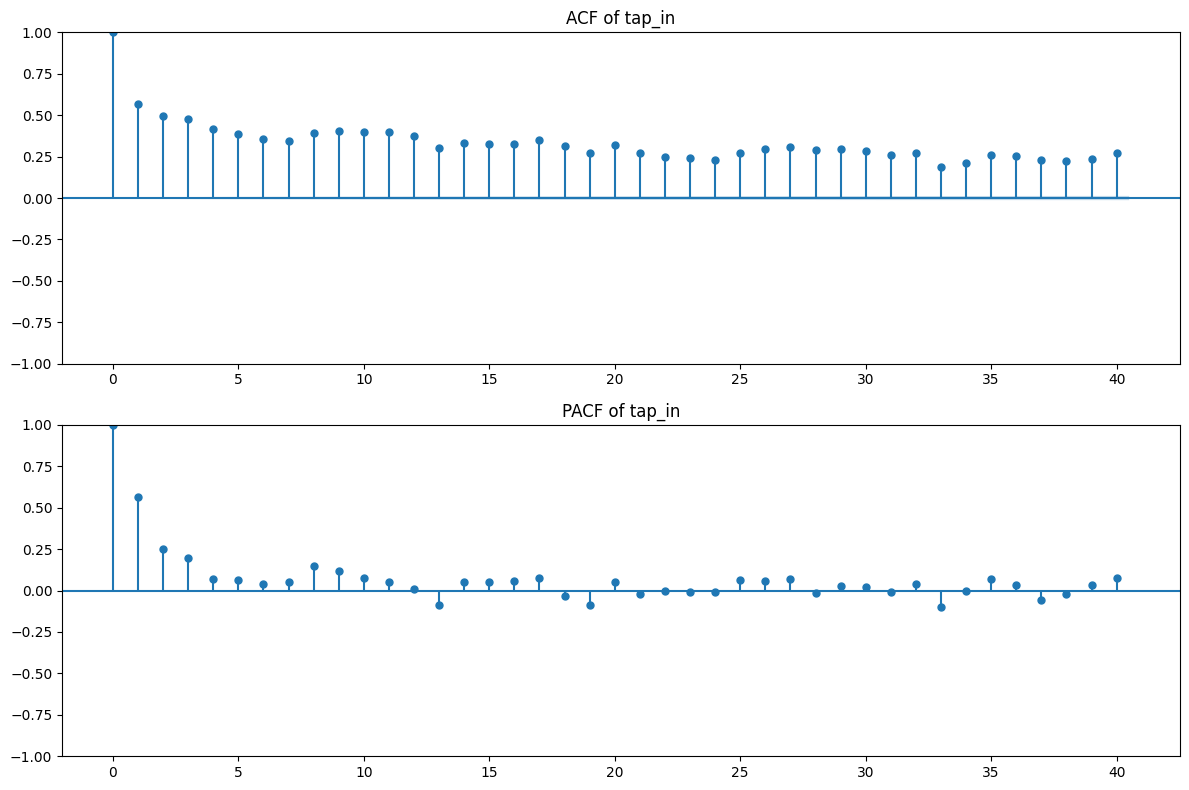

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_train.set_index('timestamp', inplace=True)
df_train.sort_index(inplace=True)
tap_in_series = df_train['tap_in'].dropna()
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(tap_in_series, lags=40, ax=ax[0])
ax[0].set_title('ACF of tap_in')

plot_pacf(tap_in_series, lags=40, ax=ax[1], method='ywm')
ax[1].set_title('PACF of tap_in')

plt.tight_layout()
plt.show()


In [ ]:
def prepare_time_series_data(merged_df, node_mapping, feature_list, lags=2):
  # if len(merged_df['is_holiday'].unique()) != 2:
  #   features = ['hour', 'air_temperature', 'relative_humidity', 'wind_speed', 'rainfall','hour_sin','hour_cos']
  #   targets = ['tap_in', 'tap_out']
  # else:
  #   features = ['hour', 'air_temperature', 'relative_humidity', 'wind_speed', 'rainfall', 'is_holiday','hour_sin','hour_cos']
  #   targets = ['tap_in', 'tap_out']
  features = feature_list
  targets = ['tap_in', 'tap_out']
  scaler_X = StandardScaler()
  scaler_y = StandardScaler()

  X = []
  y = []
  station_indices = []

  for station_id, group in merged_df.groupby('station_id'):
      if station_id not in node_mapping:
         continue
      node_idx = node_mapping[station_id]
      group = group.sort_values('timestamp')

      group = group[features + targets].fillna(0)  # Replace NA with 0

      if group[features].std().sum() == 0:
         print(f"⚠ Warning: Station {station_id} has constant feature values. Skipping...")
         continue

      station_X_base = group[features].values
      station_y = group[targets].values

      lag_features = []
      for lag in range(1, lags + 2):
         lagged = group[targets].shift(lag).fillna(0).values  # Shift and fill NaNs with 0
         lag_features.append(lagged)

      lag_features = np.hstack(lag_features)
      station_X = np.hstack([station_X_base, lag_features])  # Shape: [time_steps, len(features) + lags * len(targets)]
      station_X_scaled = scaler_X.fit_transform(station_X)
      station_y_scaled = scaler_y.fit_transform(station_y)

      station_X_scaled = station_X_scaled[lags:]
      station_y_scaled = station_y_scaled[lags:]

      X.append(station_X_scaled)
      y.append(station_y_scaled)
      station_indices.extend([node_idx] * len(station_X_scaled))

  X = torch.tensor(np.nan_to_num(np.vstack(X), nan=0.0), dtype=torch.float)
  y = torch.tensor(np.nan_to_num(np.vstack(y), nan=0.0), dtype=torch.float)
  station_indices = torch.tensor(station_indices, dtype=torch.long)

  print(f"Data Prepared: X shape {X.shape}, y shape {y.shape}, Stations: {len(set(station_indices.tolist()))}")

  return X, y, station_indices, scaler_X, scaler_y

# Step 4:  Define GNN model

In [ ]:
class PassengerVolumeGNN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, out_channels, time_feature_size=7):
        super(PassengerVolumeGNN, self).__init__()
        self.time_feature_size = time_feature_size
        self.conv1 = GATConv(node_features, hidden_channels, heads=4)
        self.conv2 = GATConv(hidden_channels * 4, hidden_channels, heads=1)
        self.sage = SAGEConv(hidden_channels, hidden_channels)

        self.time_rnn = torch.nn.GRU(time_feature_size, hidden_channels, batch_first=True)
        self.time_lin1 = torch.nn.Linear(hidden_channels + hidden_channels, hidden_channels)
        self.time_lin2 = torch.nn.Linear(hidden_channels, hidden_channels)

        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr, time_features, batch_indices):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.05, training=self.training) # 紀錄 drop out 嘗試結果，可寫進報告裡 ex, 0.2, 0.1 0.05
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.sage(x, edge_index)
        x = F.relu(x)

        time_out, _ = self.time_rnn(time_features.view(-1, 1, self.time_feature_size))
        time_out = time_out.squeeze(1)

        node_embeddings = x[batch_indices]
        combined = torch.cat([node_embeddings, time_out], dim=1)

        combined = self.time_lin1(combined)
        combined = F.relu(combined)
        combined = F.dropout(combined, p=0.05, training=self.training)
        combined = self.time_lin2(combined)
        combined = F.relu(combined)

        out = self.lin(combined)
        return out

# Step 5: Training function

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error

def train_model(
    model, node_features, edge_index, edge_attr,
    X_train, y_train, station_indices_train,
    X_val, y_val, station_indices_val,
    epochs=500, patience=20, lr=0.001
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()

        y_pred_train = model(node_features.to(device), edge_index.to(device), edge_attr.to(device), X_train.to(device), station_indices_train.to(device))
        loss = loss_fn(y_pred_train, y_train.to(device))
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # val
        model.eval()
        with torch.no_grad():
            y_pred_val = model(node_features.to(device), edge_index.to(device), edge_attr.to(device), X_val.to(device), station_indices_val.to(device))
            val_loss = loss_fn(y_pred_val, y_val.to(device))
            val_losses.append(val_loss.item())

        # Early stopping
        if val_loss.item() < best_val_loss - 1e-4:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return train_losses, val_losses


In [ ]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, tag=None):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'Training vs Validation Loss - {tag}' if tag else 'Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    if tag:
        plt.savefig(f'loss_curve_{tag}.png')
    plt.show()



def plot_predictions(y_pred, y_true, num_samples=100):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true[:num_samples, 0], label="Actual", marker='o')
    plt.plot(y_pred[:num_samples, 0], label="Predicted", marker='x')
    plt.xlabel("Sample")
    plt.ylabel("Passenger Volume")
    plt.title("Actual vs Predicted (Test Samples)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.metrics import explained_variance_score
import numpy as np

from sklearn.metrics import explained_variance_score
import numpy as np
import torch

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / np.where(denominator == 0, 1e-10, denominator)
    return np.mean(diff) * 100

def mase(y_true, y_pred, y_train, seasonality=1):
    n = y_train.shape[0]
    d = np.abs(y_train[seasonality:] - y_train[:-seasonality]).mean()
    errors = np.abs(y_true - y_pred)
    return errors.mean() / (d + 1e-10)

def evaluate_model(model, node_features, edge_index, edge_attr,
                   X_test, y_test, station_indices_test, scaler_y, y_train=None):
    model.eval()
    with torch.no_grad():
        out = model(node_features, edge_index, edge_attr, X_test, station_indices_test)

    y_pred = scaler_y.inverse_transform(out.cpu().numpy())
    y_true = scaler_y.inverse_transform(y_test.cpu().numpy())

    # Regression metrics
    mse = ((y_pred - y_true) ** 2).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(y_pred - y_true).mean()
    r2 = 1 - ((y_true - y_pred) ** 2).sum() / ((y_true - y_true.mean()) ** 2).sum()
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100
    smape_val = smape(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)

    # MASE requires y_train
    if y_train is not None:
        y_train = scaler_y.inverse_transform(y_train.cpu().numpy())
        mase_val = mase(y_true, y_pred, y_train)
    else:
        mase_val = None

    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test MAPE: {mape:.2f}%")
    print(f"Test SMAPE: {smape_val:.2f}%")
    print(f"Test R²: {r2:.4f}")
    print(f"Explained Variance Score: {evs:.4f}")
    if mase_val is not None:
        print(f"Test MASE: {mase_val:.4f}")
    else:
        print("MASE could not be calculated (y_train not provided)")

    return y_pred, y_true

def evaluate_combined_model(df, weekday_model, weekend_model,
                            node_features_wd, edge_index_wd, edge_attr_wd, scaler_y_wd,
                            node_features_we, edge_index_we, edge_attr_we, scaler_y_we,
                            X, y, station_indices):
    y_preds = []
    y_trues = []

    for i in range(len(X)):
        x_sample = X[i:i+1]  # Keep it as 2D
        y_sample = y[i:i+1]
        station_sample = station_indices[i:i+1]

        if df.iloc[i]['is_holiday'] == 1:
            pred, _ = evaluate_model(weekend_model, node_features_we, edge_index_we, edge_attr_we,
                                     x_sample, y_sample, station_sample, scaler_y_we)
        else:
            pred, _ = evaluate_model(weekday_model, node_features_wd, edge_index_wd, edge_attr_wd,
                                     x_sample, y_sample, station_sample, scaler_y_wd)

        y_preds.append(pred)
        y_trues.append(y_sample)

    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)

    plot_predictions(y_preds, y_trues)
    return y_preds, y_trues


def plot_losses(train_losses, val_losses, tag=""):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange', linewidth=2)

    plt.title(f'Training and Validation Loss Over Epochs ({tag.upper()})', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


In [ ]:
import time
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming other required functions (prepare_time_series_data, train_model, etc.) are defined
def main(df_train, df_test, tag="all"):
    start_time = time.time()

    # 1. Graph Creation
    print("1. Creating graph structure...")
    graph_start = time.time()
    node_features, edge_index, edge_attr, node_mapping = create_graph_data(df_train)
    print(f" Graph creation completed in {time.time() - graph_start:.2f} seconds.")

    # Rest of your code remains unchanged
    # 2. Time Series Preparation
    print("2. Preparing time series data...")
    ts_start = time.time()
    X_train, y_train, station_indices_train, scaler_X_train, scaler_y_train = prepare_time_series_data(df_train, node_mapping, feature_list)
    X_test, y_test, station_indices_test, scaler_X_test, scaler_y_test = prepare_time_series_data(df_test, node_mapping, feature_list)
    print(f"Time series preparation completed in {time.time() - ts_start:.2f} seconds.")

    # 3. Data Splitting
    print("3. Splitting dataset...")
    split_start = time.time()
    indices = np.arange(len(X_train))
    idx_train, idx_val = train_test_split(indices, test_size=0.2, shuffle=False)

    X_val, y_val = X_train[idx_val], y_train[idx_val]
    X_train, y_train = X_train[idx_train], y_train[idx_train]
    station_indices_val = station_indices_train[idx_val]
    station_indices_train = station_indices_train[idx_train]
    print(f" Data split completed in {time.time() - split_start:.2f} seconds.")

    # 4. Model Initialization
    print("4. Initializing GNN model...")
    model_start = time.time()
    model =PassengerVolumeGNN(
        node_features=node_features.shape[1],
        hidden_channels=64,
        out_channels=2,
        time_feature_size=X_train.shape[1]
    )
    print(f" Model initialization completed in {time.time() - model_start:.2f} seconds.")

    # 5. Training
    print("5. Training model...")
    train_start = time.time()
    train_losses, val_losses = train_model(
        model, node_features, edge_index, edge_attr,
        X_train, y_train, station_indices_train,
        X_val, y_val, station_indices_val,
        epochs=300
    )
    print(f" Training completed in {time.time() - train_start:.2f} seconds.")

    # 6. Evaluation
    print("6. Evaluating model...")
    eval_start = time.time()
    y_pred, y_true = evaluate_model(
        model, node_features, edge_index, edge_attr,
        X_test, y_test, station_indices_test, scaler_y_test
    )
    plot_predictions(y_pred, y_true)
    print(f"Evaluation completed in {time.time() - eval_start:.2f} seconds.")

    # 7. Plot Losses
    print(f"Plotting losses for {tag} model...")
    plot_losses(train_losses, val_losses, tag=tag)

    total_time = time.time() - start_time
    print(f"{tag.upper()} completed in {total_time:.2f} seconds.\n")

    return model, scaler_X_train, scaler_y_train, scaler_X_test, scaler_y_test, node_mapping



# Step 6: Modelling

## Null Model

### Weather+lat/long+time weekend/weekday model

1. Creating graph structure...
 Graph creation completed in 0.22 seconds.
2. Preparing time series data...
Data Prepared: X shape torch.Size([151067, 11]), y shape torch.Size([151067, 2]), Stations: 181
Data Prepared: X shape torch.Size([71858, 11]), y shape torch.Size([71858, 2]), Stations: 181
Time series preparation completed in 4.75 seconds.
3. Splitting dataset...
 Data split completed in 0.02 seconds.
4. Initializing GNN model...
 Model initialization completed in 0.01 seconds.
5. Training model...


100%|██████████| 300/300 [04:53<00:00,  1.02it/s]


 Training completed in 293.18 seconds.
6. Evaluating model...
Test MSE: 5370901.0000
Test RMSE: 2317.5205
Test MAE: 1437.9994
Test MAPE: 31.20%
Test SMAPE: 18.79%
Test R²: 0.8262
Explained Variance Score: 0.8278
MASE could not be calculated (y_train not provided)


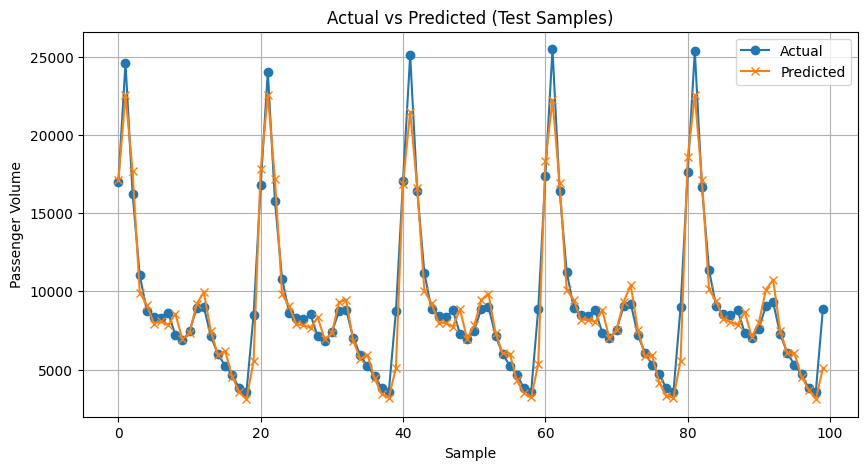

Evaluation completed in 0.33 seconds.
Plotting losses for weekday model...


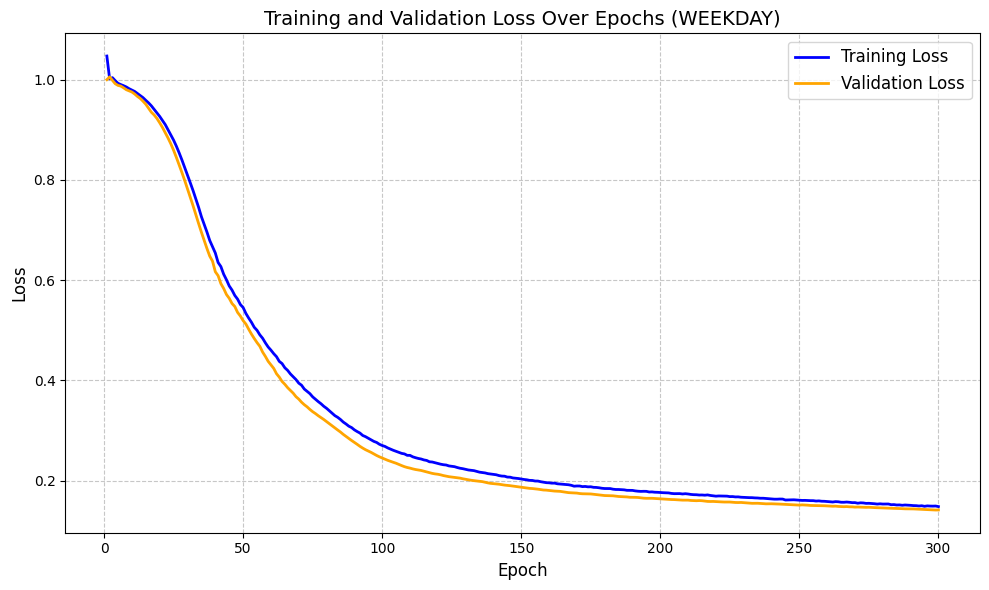

WEEKDAY completed in 298.68 seconds.

1. Creating graph structure...
 Graph creation completed in 0.13 seconds.
2. Preparing time series data...
Data Prepared: X shape torch.Size([68029, 11]), y shape torch.Size([68029, 2]), Stations: 181
Data Prepared: X shape torch.Size([39337, 11]), y shape torch.Size([39337, 2]), Stations: 181
Time series preparation completed in 1.95 seconds.
3. Splitting dataset...
 Data split completed in 0.01 seconds.
4. Initializing GNN model...
 Model initialization completed in 0.01 seconds.
5. Training model...


100%|██████████| 300/300 [02:01<00:00,  2.46it/s]


 Training completed in 121.86 seconds.
6. Evaluating model...
Test MSE: 520318.1562
Test RMSE: 721.3308
Test MAE: 502.5416
Test MAPE: 95.13%
Test SMAPE: 22.74%
Test R²: 0.8871
Explained Variance Score: 0.8863
MASE could not be calculated (y_train not provided)


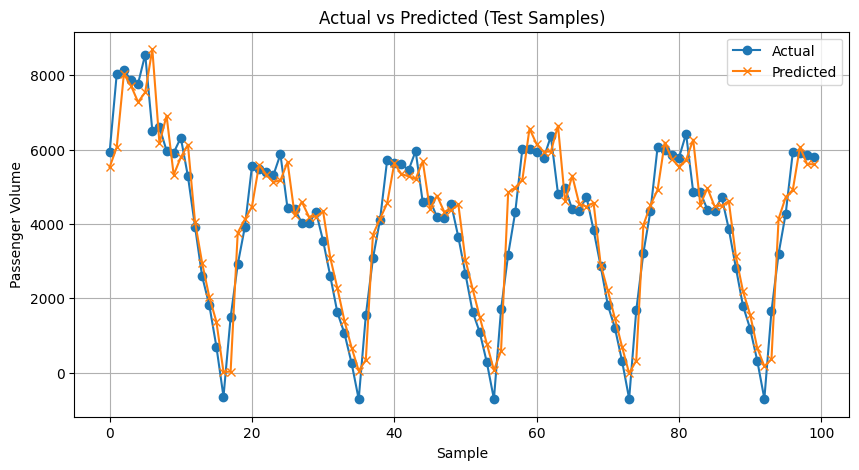

Evaluation completed in 0.40 seconds.
Plotting losses for weekend model...


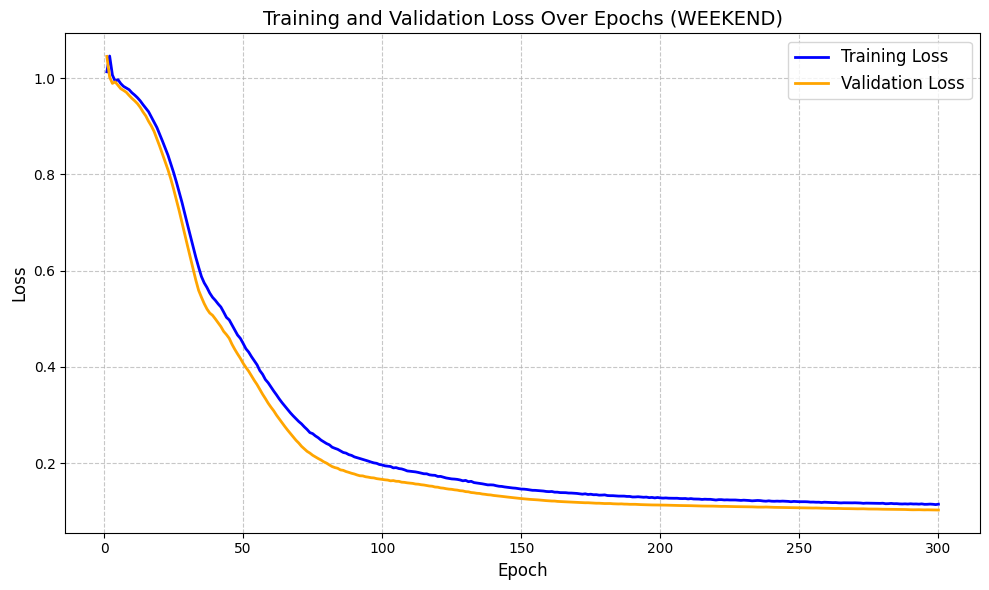

WEEKEND completed in 124.63 seconds.



In [ ]:
feature_list = ['hour', 'air_temperature', 'relative_humidity', 'wind_speed', 'rainfall']

train_weekday_data, train_weekend_data = process_passenger_volume(df_train)
test_weekday_data, test_weekend_data = process_passenger_volume(df_test)
weekday_model, scaler_X_wd_train, scaler_y_wd_train, scaler_X_wd_test, scaler_y_wd_test, node_mapping_wd = main(train_weekday_data, test_weekday_data, tag="weekday")
weekend_model, scaler_X_we, scaler_y_we, scaler_X_we_test, scaler_y_we_test, node_mapping_we = main(train_weekend_data, test_weekend_data, tag="weekend")

### all varibale weekend/weekday model

1. Creating graph structure...
 Graph creation completed in 0.13 seconds.
2. Preparing time series data...
Data Prepared: X shape torch.Size([219458, 14]), y shape torch.Size([219458, 2]), Stations: 181
Data Prepared: X shape torch.Size([111557, 14]), y shape torch.Size([111557, 2]), Stations: 181
Time series preparation completed in 2.10 seconds.
3. Splitting dataset...
 Data split completed in 0.01 seconds.
4. Initializing GNN model...
 Model initialization completed in 0.00 seconds.
5. Training model...


100%|██████████| 300/300 [09:39<00:00,  1.93s/it]


 Training completed in 579.20 seconds.
6. Evaluating model...
Test MSE: 3503573.5000
Test RMSE: 1871.7834
Test MAE: 1074.2975
Test MAPE: 38.11%
Test SMAPE: 18.18%
Test R²: 0.8750
Explained Variance Score: 0.8763
MASE could not be calculated (y_train not provided)


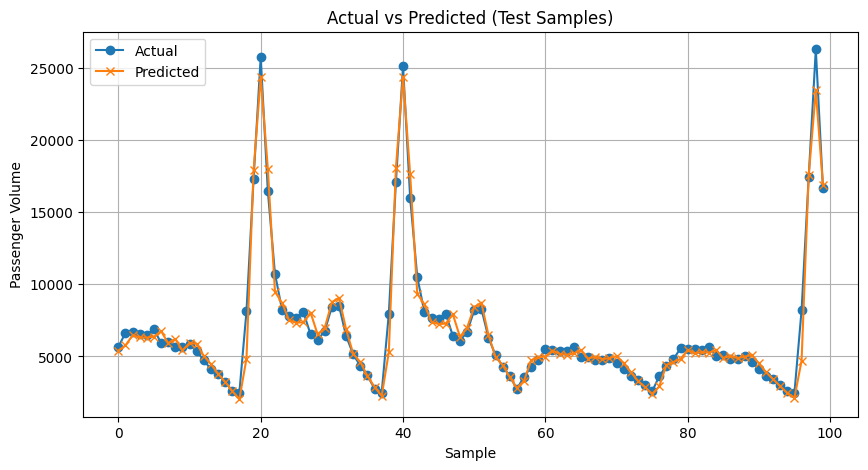

Evaluation completed in 0.45 seconds.
Plotting losses for all_variable model...


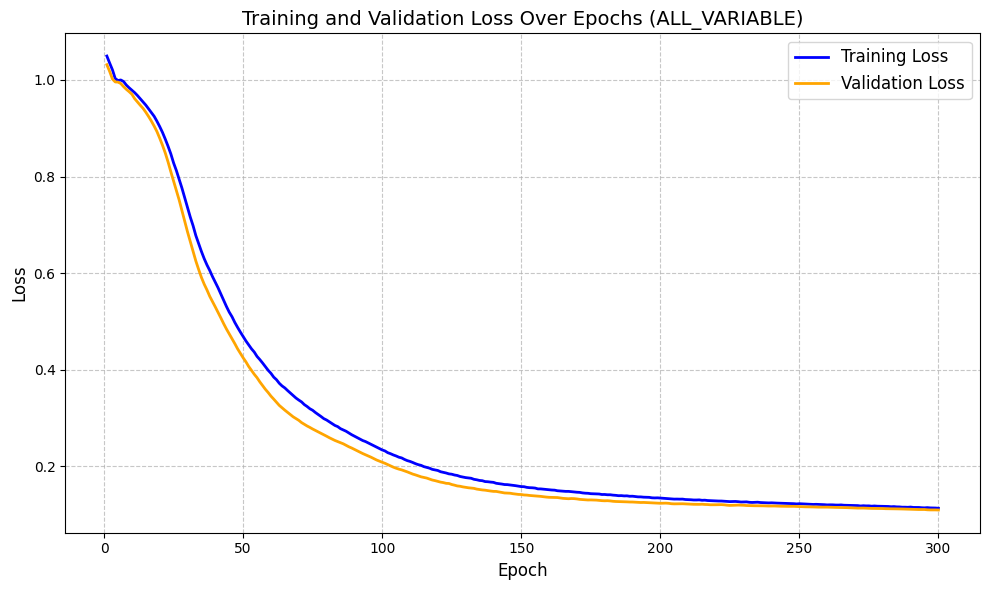

ALL_VARIABLE completed in 582.07 seconds.



In [ ]:
feature_list = ['hour', 'air_temperature', 'relative_humidity', 'wind_speed', 'rainfall', 'is_holiday','hour_sin','hour_cos']
df_train_clean_variable = process_passenger_volume(df_train, False)
df_test_clean_variable = process_passenger_volume(df_test, False)
all_model, scaler_X_train, scaler_y_train, scaler_X_test, scaler_y_test, node_mapping = main(df_train_clean_variable, df_test_clean_variable, tag="all_variable")

## Reduced MOdel

In [ ]:
def is_transfer_hub(station_id):
    if '/' in str(station_id):
        return 1
    else:
        return 0

In [ ]:
df_train['is_transfer_hub'] = df_train['station_id'].apply(is_transfer_hub)
df_test['is_transfer_hub'] = df_test['station_id'].apply(is_transfer_hub)

In [ ]:
print(f"Train data has {df_train.shape[0]} rows with {sorted(list(df_train.columns))} features")
print(f"Test data has {df_test.shape[0]} rows with {sorted(list(df_test.columns))} features")

Train data has 219833 rows with ['Latitude', 'Longitude', 'Visitors', 'air_temperature', 'is_holiday', 'is_transfer_hub', 'rainfall', 'relative_humidity', 'station_id', 'tap_in', 'tap_out', 'timestamp', 'wind_speed'] features
Test data has 111919 rows with ['Latitude', 'Longitude', 'Visitors', 'air_temperature', 'is_holiday', 'is_transfer_hub', 'rainfall', 'relative_humidity', 'station_id', 'tap_in', 'tap_out', 'timestamp', 'wind_speed'] features


### Weather+lat/long+time all model

1. Creating graph structure...
 Graph creation completed in 0.15 seconds.
2. Preparing time series data...
Data Prepared: X shape torch.Size([151067, 13]), y shape torch.Size([151067, 2]), Stations: 181
Data Prepared: X shape torch.Size([71858, 13]), y shape torch.Size([71858, 2]), Stations: 181
Time series preparation completed in 2.55 seconds.
3. Splitting dataset...
 Data split completed in 0.02 seconds.
4. Initializing GNN model...
 Model initialization completed in 0.01 seconds.
5. Training model...


100%|██████████| 300/300 [04:45<00:00,  1.05it/s]


 Training completed in 285.30 seconds.
6. Evaluating model...
Test MSE: 6304048.5000
Test RMSE: 2510.7864
Test MAE: 1606.3489
Test MAPE: 38.39%
Test SMAPE: 20.65%
Test R²: 0.7960
Explained Variance Score: 0.7970
MASE could not be calculated (y_train not provided)


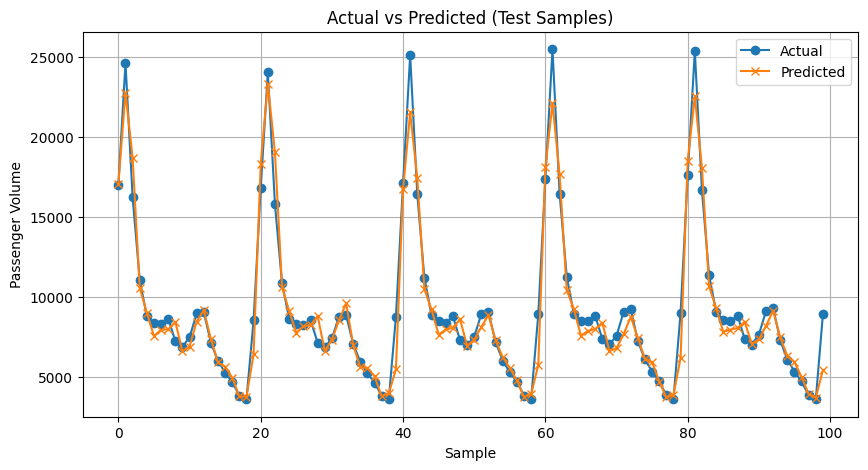

Evaluation completed in 0.34 seconds.
Plotting losses for weekday model...


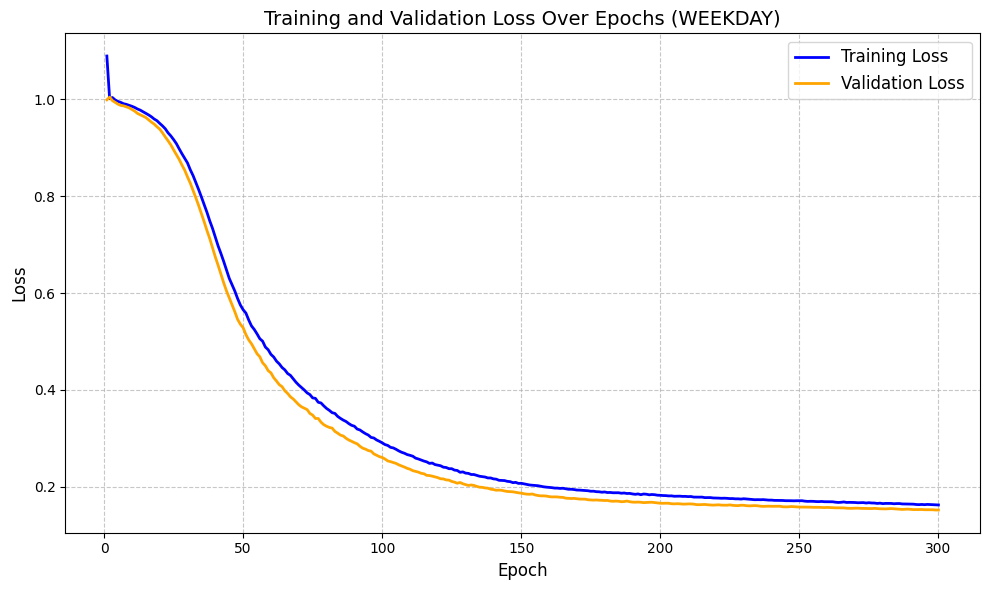

WEEKDAY completed in 288.54 seconds.

1. Creating graph structure...
 Graph creation completed in 0.14 seconds.
2. Preparing time series data...
Data Prepared: X shape torch.Size([68029, 13]), y shape torch.Size([68029, 2]), Stations: 181
Data Prepared: X shape torch.Size([39337, 13]), y shape torch.Size([39337, 2]), Stations: 181
Time series preparation completed in 1.66 seconds.
3. Splitting dataset...
 Data split completed in 0.00 seconds.
4. Initializing GNN model...
 Model initialization completed in 0.00 seconds.
5. Training model...


100%|██████████| 300/300 [01:54<00:00,  2.63it/s]


 Training completed in 114.24 seconds.
6. Evaluating model...
Test MSE: 536365.0625
Test RMSE: 732.3695
Test MAE: 520.7784
Test MAPE: 102.62%
Test SMAPE: 23.39%
Test R²: 0.8836
Explained Variance Score: 0.8831
MASE could not be calculated (y_train not provided)


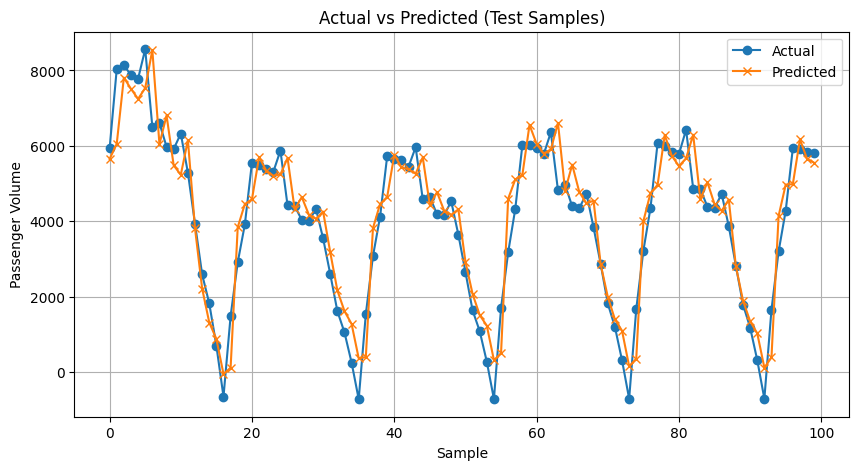

Evaluation completed in 0.27 seconds.
Plotting losses for weekend model...


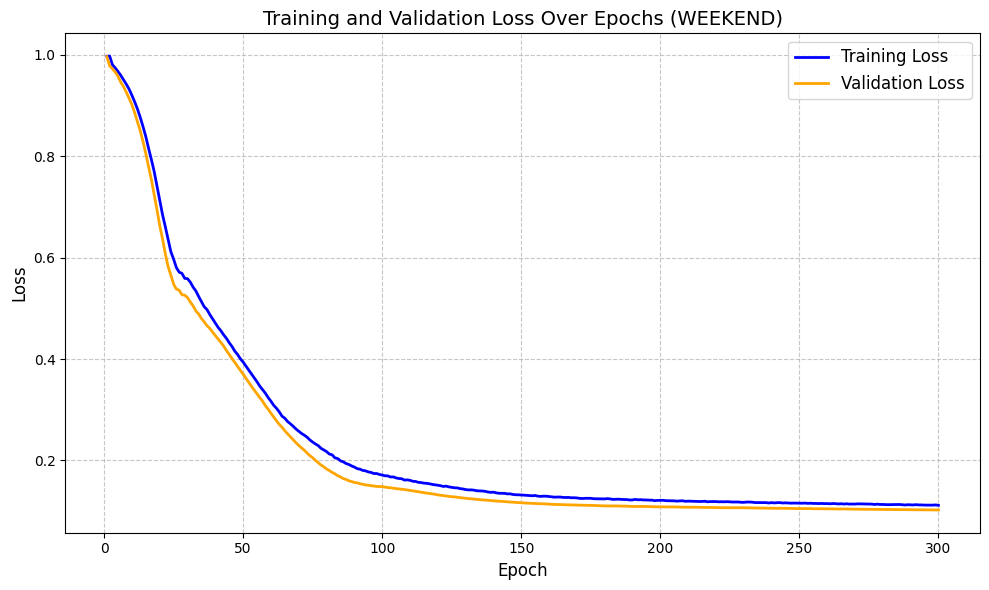

WEEKEND completed in 116.48 seconds.



In [ ]:
feature_list = ['hour', 'air_temperature', 'relative_humidity', 'wind_speed', 'rainfall','Visitors','is_transfer_hub']
train_weekday_data, train_weekend_data = process_passenger_volume(df_train)
test_weekday_data, test_weekend_data = process_passenger_volume(df_test)

weekday_model, scaler_X_wd_train, scaler_y_wd_train, scaler_X_wd_test, scaler_y_wd_test, node_mapping_wd = main(train_weekday_data, test_weekday_data, tag="weekday")
weekend_model, scaler_X_we, scaler_y_we, scaler_X_we_test, scaler_y_we_test, node_mapping_we = main(train_weekend_data, test_weekend_data, tag="weekend")

### all varibale all model

1. Creating graph structure...
 Graph creation completed in 0.15 seconds.
2. Preparing time series data...
Data Prepared: X shape torch.Size([219458, 14]), y shape torch.Size([219458, 2]), Stations: 181
Data Prepared: X shape torch.Size([111557, 14]), y shape torch.Size([111557, 2]), Stations: 181
Time series preparation completed in 2.14 seconds.
3. Splitting dataset...
 Data split completed in 0.01 seconds.
4. Initializing GNN model...
 Model initialization completed in 0.00 seconds.
5. Training model...


100%|██████████| 300/300 [10:12<00:00,  2.04s/it]


 Training completed in 612.16 seconds.
6. Evaluating model...
Test MSE: 4344276.5000
Test RMSE: 2084.2927
Test MAE: 1195.0671
Test MAPE: 38.11%
Test SMAPE: 18.89%
Test R²: 0.8450
Explained Variance Score: 0.8463
MASE could not be calculated (y_train not provided)


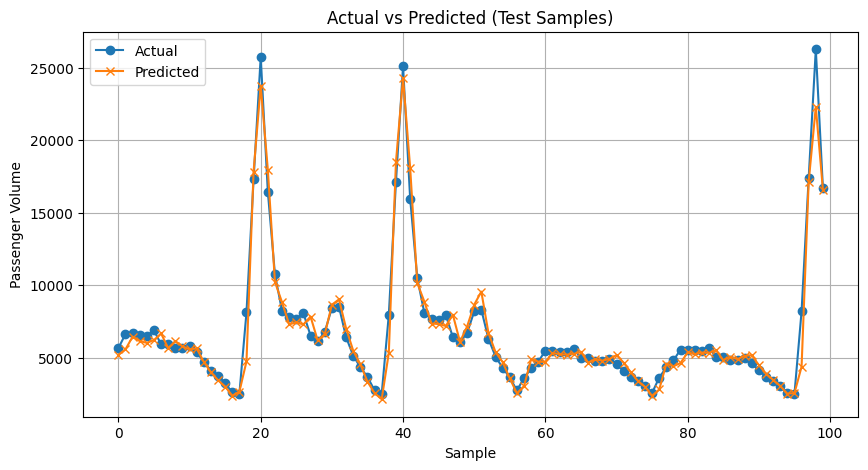

Evaluation completed in 0.48 seconds.
Plotting losses for all_variable model...


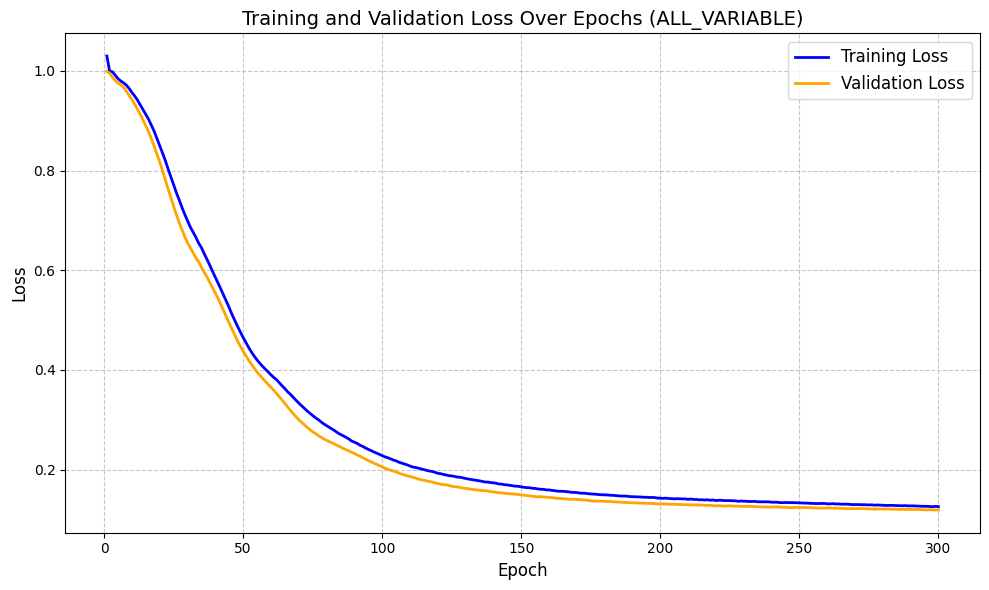

ALL_VARIABLE completed in 615.13 seconds.



In [ ]:
feature_list = ['hour', 'air_temperature', 'relative_humidity', 'wind_speed', 'rainfall', 'is_holiday','Visitors','is_transfer_hub']
df_train_clean_variable = process_passenger_volume(df_train, False)
df_test_clean_variable = process_passenger_volume(df_test, False)
all_model, scaler_X_train, scaler_y_train, scaler_X_test, scaler_y_test, node_mapping = main(df_train_clean_variable, df_test_clean_variable, tag="all_variable")

## Full Model

### all varibale weekend/weekday model + hour_sin/hour_cos

1. Creating graph structure...
 Graph creation completed in 0.13 seconds.
2. Preparing time series data...
Data Prepared: X shape torch.Size([151067, 15]), y shape torch.Size([151067, 2]), Stations: 181
Data Prepared: X shape torch.Size([71858, 15]), y shape torch.Size([71858, 2]), Stations: 181
Time series preparation completed in 1.95 seconds.
3. Splitting dataset...
 Data split completed in 0.01 seconds.
4. Initializing GNN model...
 Model initialization completed in 0.00 seconds.
5. Training model...


100%|██████████| 300/300 [05:43<00:00,  1.14s/it]


 Training completed in 343.48 seconds.
6. Evaluating model...
Test MSE: 4830803.5000
Test RMSE: 2197.9089
Test MAE: 1351.6155
Test MAPE: 48.01%
Test SMAPE: 17.96%
Test R²: 0.8437
Explained Variance Score: 0.8461
MASE could not be calculated (y_train not provided)


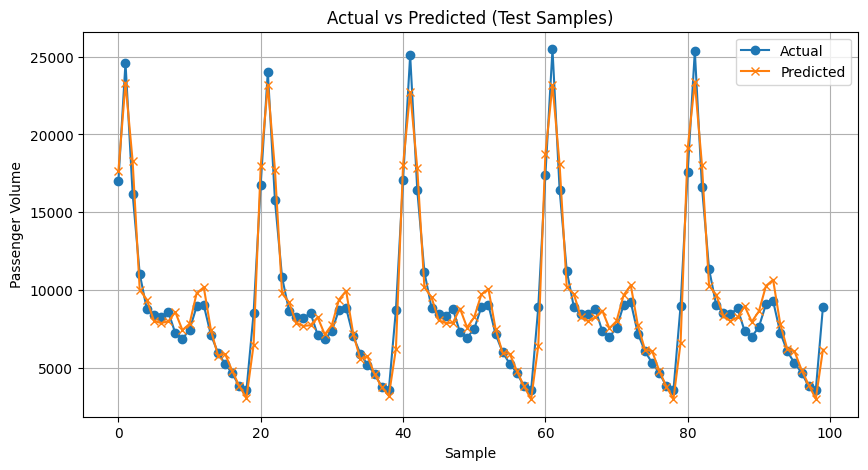

Evaluation completed in 0.50 seconds.
Plotting losses for weekday_sin_cos model...


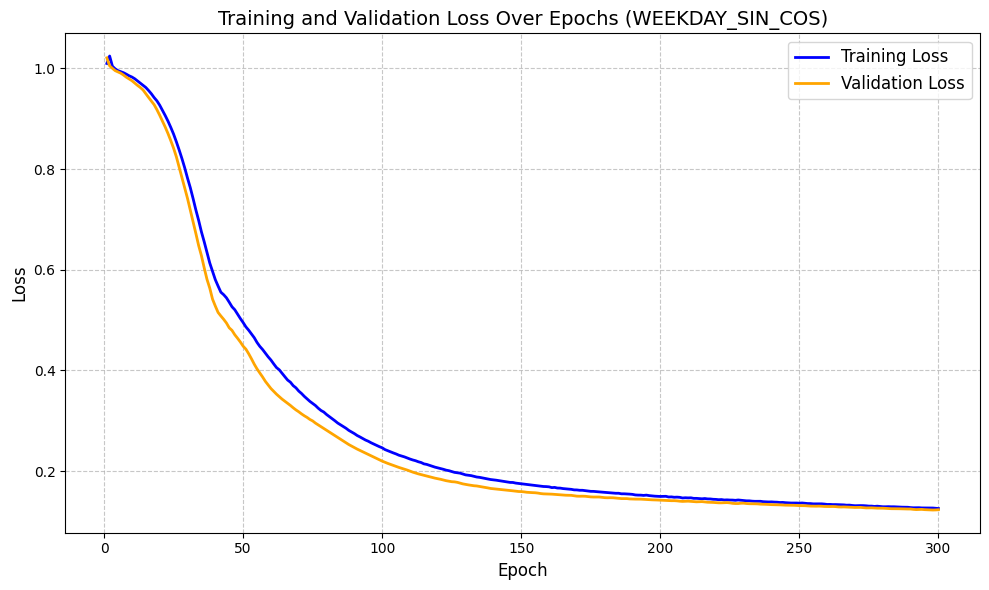

WEEKDAY_SIN_COS completed in 346.32 seconds.

1. Creating graph structure...
 Graph creation completed in 0.18 seconds.
2. Preparing time series data...
Data Prepared: X shape torch.Size([68029, 15]), y shape torch.Size([68029, 2]), Stations: 181
Data Prepared: X shape torch.Size([39337, 15]), y shape torch.Size([39337, 2]), Stations: 181
Time series preparation completed in 2.44 seconds.
3. Splitting dataset...
 Data split completed in 0.01 seconds.
4. Initializing GNN model...
 Model initialization completed in 0.00 seconds.
5. Training model...


100%|██████████| 300/300 [02:01<00:00,  2.48it/s]


 Training completed in 121.21 seconds.
6. Evaluating model...
Test MSE: 490941.1562
Test RMSE: 700.6719
Test MAE: 490.7978
Test MAPE: 90.12%
Test SMAPE: 22.55%
Test R²: 0.8935
Explained Variance Score: 0.8926
MASE could not be calculated (y_train not provided)


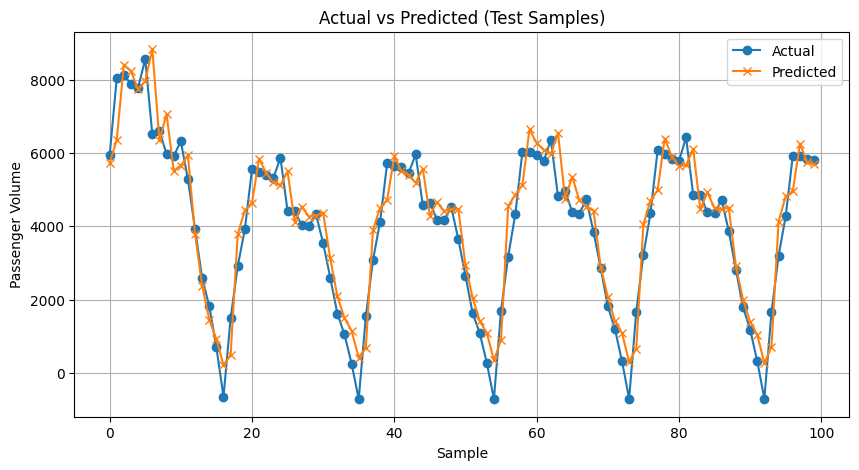

Evaluation completed in 0.37 seconds.
Plotting losses for weekend_sin_cos model...


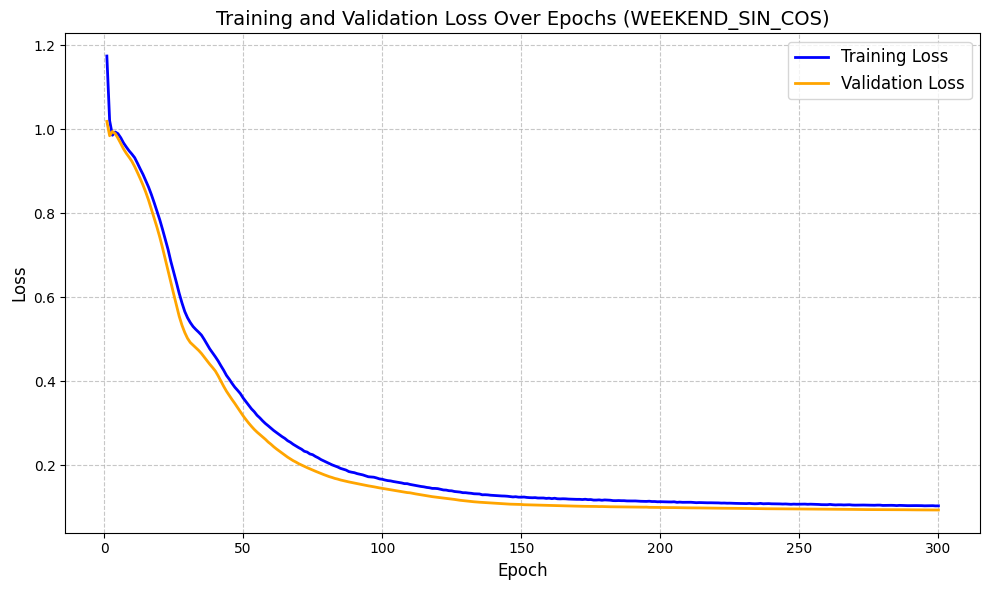

WEEKEND_SIN_COS completed in 124.48 seconds.



In [ ]:
feature_list = ['hour', 'air_temperature', 'relative_humidity', 'wind_speed', 'rainfall','Visitors','is_transfer_hub','hour_sin','hour_cos']
train_weekday_data, train_weekend_data = process_passenger_volume(df_train)
test_weekday_data, test_weekend_data = process_passenger_volume(df_test)

weekday_model, scaler_X_wd_train, scaler_y_wd_train, scaler_X_wd_test, scaler_y_wd_test, node_mapping_wd = main(train_weekday_data, test_weekday_data, tag="weekday_sin_cos")
weekend_model, scaler_X_we, scaler_y_we, scaler_X_we_test, scaler_y_we_test, node_mapping_we = main(train_weekend_data, test_weekend_data, tag="weekend_sin_cos")

### all varibale allmodel + hour_sin/hour_cos

1. Creating graph structure...
 Graph creation completed in 0.17 seconds.
2. Preparing time series data...
Data Prepared: X shape torch.Size([219458, 16]), y shape torch.Size([219458, 2]), Stations: 181
Data Prepared: X shape torch.Size([111557, 16]), y shape torch.Size([111557, 2]), Stations: 181
Time series preparation completed in 2.29 seconds.
3. Splitting dataset...
 Data split completed in 0.01 seconds.
4. Initializing GNN model...
 Model initialization completed in 0.00 seconds.
5. Training model...


100%|██████████| 300/300 [11:32<00:00,  2.31s/it]


 Training completed in 692.99 seconds.
6. Evaluating model...
Test MSE: 3524991.0000
Test RMSE: 1877.4960
Test MAE: 1089.5063
Test MAPE: 42.05%
Test SMAPE: 18.57%
Test R²: 0.8742
Explained Variance Score: 0.8753
MASE could not be calculated (y_train not provided)


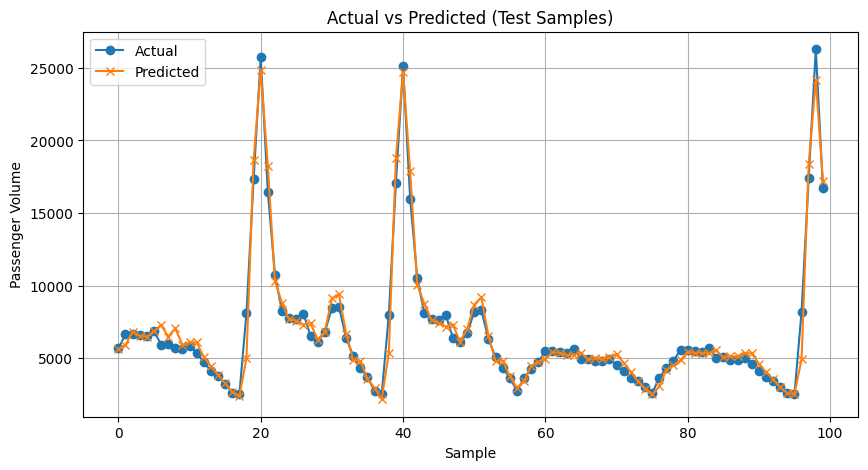

Evaluation completed in 0.49 seconds.
Plotting losses for all_variable_sin_cos model...


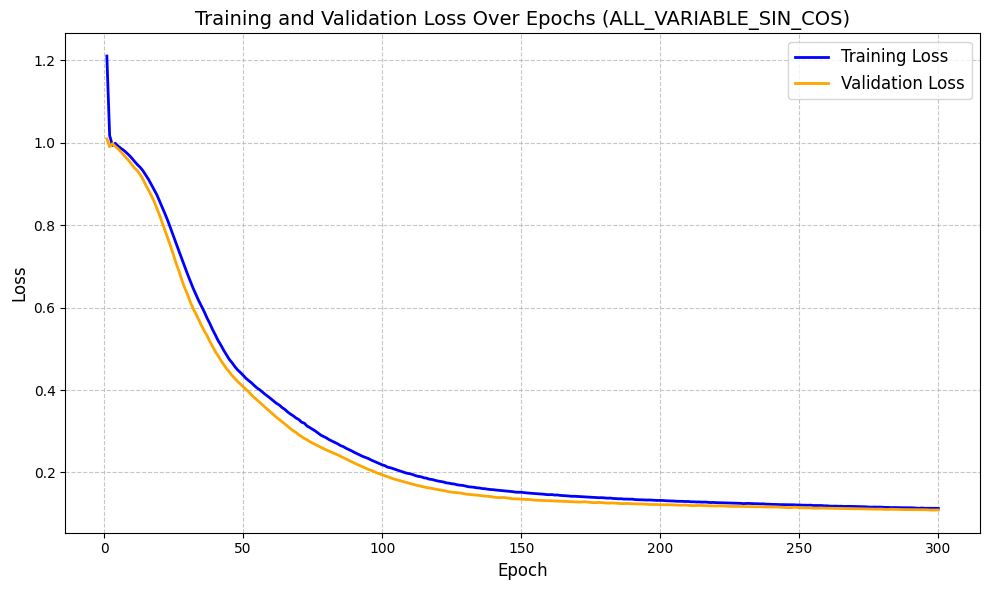

ALL_VARIABLE_SIN_COS completed in 696.15 seconds.



In [ ]:
feature_list = ['hour', 'air_temperature', 'relative_humidity', 'wind_speed', 'rainfall', 'is_holiday','Visitors','is_transfer_hub','hour_sin','hour_cos']
df_train_clean_variable = process_passenger_volume(df_train, False)
df_test_clean_variable = process_passenger_volume(df_test, False)
all_model, scaler_X_train, scaler_y_train, scaler_X_test, scaler_y_test, node_mapping = main(df_train_clean_variable, df_test_clean_variable, tag="all_variable_sin_cos")